# Imports

In [2]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio.v2 as imageio
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import glob
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
import torchaudio

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading the data

## Global data

We first load the CSV file with the data of all participants, then we will use it to make a wider dataset with all the recordings

In [4]:
df = pd.read_csv('D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\D3T3C\D3TEC Dataset\Dataset.csv')
df.head()

,Marca temporal,Participant_ID,PHQ-9 Score,Age,Gender,Lugar de Residencia,Lugar de Procedencia,Social Class,Institution,Medicine,Physical Condition,Mental Health Condition,Depression Diagnosis (level)
0,2023/10/11 11:13:07 a. m. GMT-6,1,8,36,Female,"Santa Catarina, Nuevo León",NaN,Working Class,CAABI,Forxiga. Atrovastatina.,Diabetes. Fatty Liver.,NaN,NaN
1,2023/10/11 1:13:47 p. m. GMT-6,2,1,57,Female,"Santa Catarina, Nuevo León",NaN,Working Class,CAABI,Metformina,NaN,NaN,NaN
2,2023/10/11 1:57:08 p. m. GMT-6,3,3,62,Female,"San Pedro, Nuevo León",NaN,Upper Class,CAABI,Sertrialina,Estenosis Espinal,Ansiedad,NaN
3,2023/10/11 3:02:28 p. m. GMT-6,4,13,48,Female,"Santa Catarina, Nuevo León",NaN,Working Class,CAABI,NaN,NaN,NaN,NaN
4,2023/10/11 4:11:32 p. m. GMT-6,5,7,40,Female,"Santa Catarina, Nuevo León",NaN,Middle Class,CAABI,Homeopatía.,NaN,Moderate Anxiety.,NaN


### Checking types

In [5]:
df.dtypes

Marca temporal                  object
Participant_ID                   int64
PHQ-9 Score                      int64
Age                              int64
Gender                          object
Lugar de Residencia             object
Lugar de Procedencia            object
Social Class                    object
Institution                     object
Medicine                        object
Physical Condition              object
Mental Health Condition         object
Depression Diagnosis (level)    object
dtype: object

### Adding binary classification

In [6]:
# Crear la nueva columna "PHQ-Binary" basada en "PHQ-9 Score"
df['PHQ-Binary'] = df['PHQ-9 Score'].apply(lambda x: 1 if x >= 10 else 0)
df

,Marca temporal,Participant_ID,PHQ-9 Score,Age,Gender,Lugar de Residencia,Lugar de Procedencia,Social Class,Institution,Medicine,Physical Condition,Mental Health Condition,Depression Diagnosis (level),PHQ-Binary
0,2023/10/11 11:13:07 a. m. GMT-6,1,8,36,Female,"Santa Catarina, Nuevo León",NaN,Working Class,CAABI,Forxiga. Atrovastatina.,Diabetes. Fatty Liver.,NaN,NaN,0
1,2023/10/11 1:13:47 p. m. GMT-6,2,1,57,Female,"Santa Catarina, Nuevo León",NaN,Working Class,CAABI,Metformina,NaN,NaN,NaN,0
2,2023/10/11 1:57:08 p. m. GMT-6,3,3,62,Female,"San Pedro, Nuevo León",NaN,Upper Class,CAABI,Sertrialina,Estenosis Espinal,Ansiedad,NaN,0
3,2023/10/11 3:02:28 p. m. GMT-6,4,13,48,Female,"Santa Catarina, Nuevo León",NaN,Working Class,CAABI,NaN,NaN,NaN,NaN,1
4,2023/10/11 4:11:32 p. m. GMT-6,5,7,40,Female,"Santa Catarina, Nuevo León",NaN,Middle Class,CAABI,Homeopatía.,NaN,Moderate Anxiety.,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2024/04/09 5:28:51 p. m. GMT-6,149,12,19,Male,"Monterrey, Nuevo León.","Bogotá, Colombia.",Upper Class,TEC,NaN,NaN,NaN,NaN,1
58,2024/04/10 4:17:26 p. m. GMT-6,150,12,20,Female,"Monterrey, Nuevo León.",San Luis Potosí,Middle Class,TEC,NaN,NaN,NaN,NaN,1
59,2024/04/10 4:18:06 p. m. GMT-6,151,4,20,Male,"Monterrey, Nuevo León.","Monterrey, Nuevo León.",Upper Class,TEC,NaN,NaN,NaN,NaN,0
60,2024/04/10 4:18:50 p. m. GMT-6,152,5,22,Male,"Monterrey, Nuevo León.",Oaxaca de Juárez,Upper Class,TEC,NaN,NaN,NaN,NaN,0


### Treat data frame as dict

In [7]:
df_dict = df.set_index('Participant_ID').to_dict('index')
df_dict

{1: {'Marca temporal': '2023/10/11 11:13:07 a.\xa0m. GMT-6',
  'PHQ-9 Score': 8,
  'Age': 36,
  'Gender': 'Female',
  'Lugar de Residencia': 'Santa Catarina, Nuevo León',
  'Lugar de Procedencia': nan,
  'Social Class': 'Working Class',
  'Institution': 'CAABI',
  'Medicine': 'Forxiga. Atrovastatina.',
  'Physical Condition': 'Diabetes. Fatty Liver.',
  'Mental Health Condition': nan,
  'Depression Diagnosis (level)': nan,
  'PHQ-Binary': 0},
 2: {'Marca temporal': '2023/10/11 1:13:47 p.\xa0m. GMT-6',
  'PHQ-9 Score': 1,
  'Age': 57,
  'Gender': 'Female',
  'Lugar de Residencia': 'Santa Catarina, Nuevo León',
  'Lugar de Procedencia': nan,
  'Social Class': 'Working Class',
  'Institution': 'CAABI',
  'Medicine': 'Metformina',
  'Physical Condition': nan,
  'Mental Health Condition': nan,
  'Depression Diagnosis (level)': nan,
  'PHQ-Binary': 0},
 3: {'Marca temporal': '2023/10/11 1:57:08 p.\xa0m. GMT-6',
  'PHQ-9 Score': 3,
  'Age': 62,
  'Gender': 'Female',
  'Lugar de Residencia': '

### Helper function definition

#### Spectrogram generator

In [71]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def extract_question_number(file_name):
    parts = file_name.split('_')
    if len(parts) >= 2:
        try:
            return int(parts[-1].split('.')[0])
        except ValueError:
            return 0
    return 0

def load_audios_multiple_sources(data_dict, sources):
    """
    Load audios from multiple sources and types into the data_dict using librosa,
    and generate both standard and Mel spectrograms.
    
    Args:
    - data_dict (dict): Dictionary with the participants' information.
    - sources (dict): Dictionary where keys are audio types and values are their respective base paths.
    
    Returns:
    - data_dict (dict): Updated dictionary with the loaded audios and their spectrograms.
    """
    total_sources = len(sources)
    source_count = 0
    for audio_type, base_path in sources.items():
        source_count += 1
        print(f"Processing source {source_count} of {total_sources}: {audio_type}")
        
        audio_files = os.listdir(base_path)
        total_files = len(audio_files)
        processed_files = 0
        
        for file in audio_files:
            if file == '.DS_Store':
                continue
            processed_files += 1
            if processed_files % 10 == 0:
                print(f"Processed {processed_files} of {total_files} files in {audio_type}")
            
            file_path = os.path.join(base_path, file)
            question_number = extract_question_number(file)
            
            audio_time_series, sample_rate = librosa.load(file_path)
            
            # Generate the STFT spectrogram
            stft_spectrogram = librosa.stft(audio_time_series)
            spectrogram_db = librosa.amplitude_to_db(np.abs(stft_spectrogram), ref=np.max)
            
            # Generate the Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_time_series, sr=sample_rate)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            
            # Convert the spectrogram to a numpy array if it's a tensor
            if not isinstance(spectrogram_db, np.ndarray):
                spectrogram_db = spectrogram_db.numpy()
            
            # Use np.squeeze to remove single-dimensional entries from the shape
            spectrogram_data = np.squeeze(spectrogram_db)

            
            # Update data_dict with audio and spectrogram info
            for participant_id, info in data_dict.items():
                if 'audios' not in info:
                    info['audios'] = {}
                if audio_type not in info['audios']:
                    info['audios'][audio_type] = {}
                
                info['audios'][audio_type][question_number] = {
                    'file_path': file_path,
                    'waveform': audio_time_series,
                    'sample_rate': sample_rate,
                    'spectrogram': spectrogram_data,
                    'mel_spectrogram': mel_spectrogram_db
                }
    print("All sources processed.")
    return data_dict

In [ ]:
# Define the sources
sources = {
    'sm': 'D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/D3T3C/D3TEC Dataset/SM-27',
    'mobile': 'D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/D3T3C/D3TEC Dataset/iPhoneSE2020'
}

# Load audios from both sources
data_dict_updated = load_audios_multiple_sources(df_dict, sources)

# Verify the content of the updated dictionary
data_dict_updated

#### Export to pickle to save and load the data

In [77]:
import pickle

def save_data_dict_to_file(filename, data_dict):
    """
    Save the data_dict dictionary to a file using pickle.

    Parameters:
    - filename (str): The name of the file to save the data_dict to.
    - data_dict (dict): The dictionary containing the data to be saved.

    Returns:
    None
    """
    # Open a file in write-binary (wb) mode
    with open(filename, 'wb') as file:
        # Use pickle.dump() to write the data_dict dictionary to the file
        pickle.dump(data_dict, file)

    print(f'data_dict has been saved to {filename}')

# Specify the filename for saving
filename = 'D3TEC.pkl'

# Call the save_data_dict_to_file function to save the data_dict_updated dictionary
save_data_dict_to_file(filename, data_dict_updated)


data_dict_updated has been saved to D3TEC.pkl


In [ ]:
def load_data(filename):
    """
    Load data from a pickle file.

    Args:
        filename (str): The path to the pickle file.

    Returns:
        dict: The loaded data dictionary.
    """
    with open(filename, 'rb') as file:
        data_dict_loaded = pickle.load(file)
    return data_dict_loaded

data_dict_loaded = load_data(filename)
data_dict_loaded

#### Testing the spectrograms

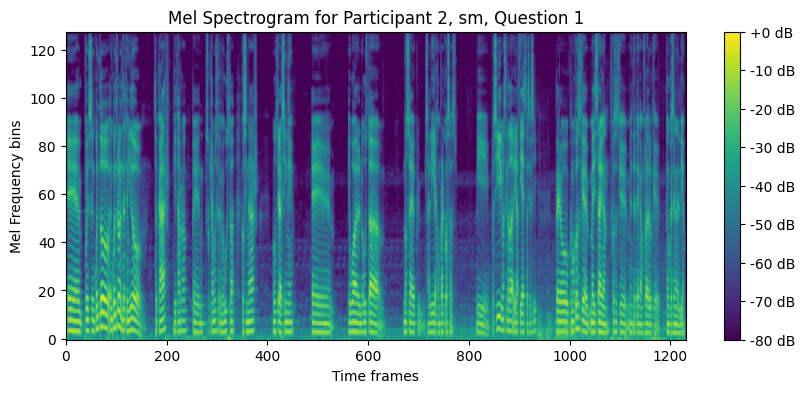

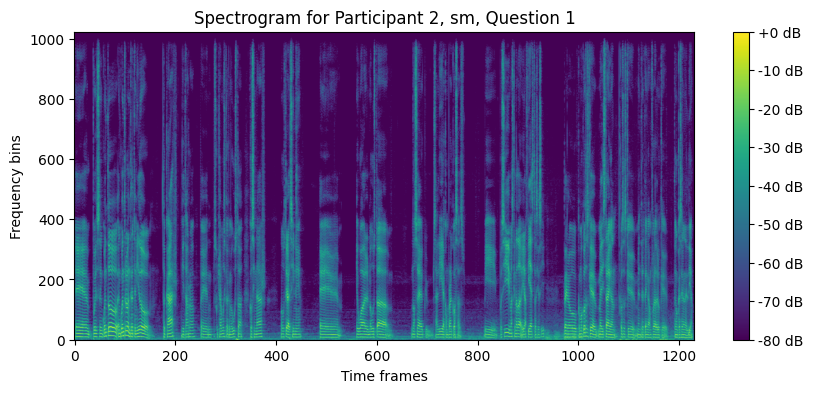

In [80]:
import matplotlib.pyplot as plt
import numpy as np

participant_id = 2  # Replace with the actual participant ID
audio_type = 'sm'  # Replace with 'sm' or 'mobile'
question_number = 1  # Replace with the actual question number

# Retrieve both spectrograms
mel_spectrogram_data = data_dict_updated[participant_id]['audios'][audio_type][question_number]['mel_spectrogram']
spectrogram_data = data_dict_updated[participant_id]['audios'][audio_type][question_number]['spectrogram']

# Convert the Mel spectrogram to a numpy array if it's a tensor
if not isinstance(mel_spectrogram_data, np.ndarray):
    mel_spectrogram_data = mel_spectrogram_data.numpy()

# Convert the standard spectrogram to a numpy array if it's a tensor
if not isinstance(spectrogram_data, np.ndarray):
    spectrogram_data = spectrogram_data.numpy()

# Squeeze both spectrograms
mel_spectrogram_data = np.squeeze(mel_spectrogram_data)
spectrogram_data = np.squeeze(spectrogram_data)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram_data, aspect='auto', origin='lower')
plt.title(f'Mel Spectrogram for Participant {participant_id}, {audio_type}, Question {question_number}')
plt.ylabel('Mel Frequency bins')
plt.xlabel('Time frames')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot the standard spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_data, aspect='auto', origin='lower')
plt.title(f'Spectrogram for Participant {participant_id}, {audio_type}, Question {question_number}')
plt.ylabel('Frequency bins')
plt.xlabel('Time frames')
plt.colorbar(format='%+2.0f dB')
plt.show()

## SM-27

In [37]:
df_test[152]['audios']["mobile"][1].keys()

dict_keys(['sm', 'mobile'])

In [ ]:
df_sm =""

## iPhone SE 2020

In [ ]:
df_iphone=  ""

# Data processing

## Spectrograms